## LAPD vehicle related crime hotspots 2016

### I am trying to predict where and when in LA your vehicle is likely to be stolen 

The data is from LAPD open data : https://data.lacity.org/A-Safe-City/LAPD-Crime-and-Collision-Raw-Data-for-2015/ttiz-7an8/data
<p> My client can be **LAPD** and **insurance companies**.

### Summary
<li> Vehicles can be stolen throughout the year.
<li> More vehicle thefts are observed on Fridays and Saturdays.
<li> I looked for areas with more than 2500 incidents/year and ran a K-means clustering model to find the centroids of those areas.
<li> I tried to get insights of those areas, e.g., if the locations are residential areas, parking lots, movie theatres or highways. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib as plt
import seaborn as sns
%matplotlib inline

In [2]:
df = pd.read_csv('LAPD_Crime_and_Collision_Raw_Data_for_2015.csv', parse_dates=(['Date Rptd', 'DATE OCC']))
df.head(2)

,Date Rptd,DR. NO,DATE OCC,TIME OCC,AREA,AREA NAME,RD,Crm Cd,Crm Cd Desc,Status,Status Desc,LOCATION,Cross Street,Location 1
0,2016-09-28 12:00:00,160917742,2016-09-27 12:00:00,900,9,Van Nuys,926,510,VEHICLE - STOLEN,IC,Invest Cont,CALHOUN,GILMORE,"(34.1877, -118.4421)"
1,2016-02-06 12:00:00,161505983,2016-02-05 12:00:00,1730,15,N Hollywood,1517,510,VEHICLE - STOLEN,IC,Invest Cont,11206 VANOWEN ST,NaN,"(34.194, -118.3746)"


In [3]:
df['DATE OCC'].min()

Timestamp('2016-01-01 12:00:00')

In [4]:
df['DATE OCC'].max()

Timestamp('2016-12-03 12:00:00')

In [5]:
df2 = df[['DATE OCC', 'Location 1', 'TIME OCC']]
df2 = df2.sort_values ('DATE OCC')
df2.columns = [['o_date', 'loc', 'time']]
df2.head(2)

,o_date,loc,time
33849,2016-01-01 12:00:00,"(34.2504, -118.5199)",300
28785,2016-01-01 12:00:00,"(34.0911, -118.2619)",1830


In [6]:
df2.isnull().values.any()

False

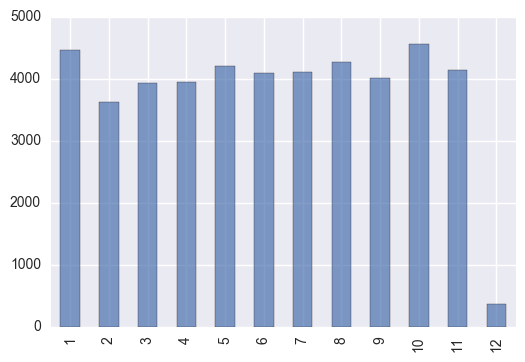

In [7]:
df2.o_date.dt.month.value_counts().sort_index().plot(kind = 'bar', alpha = 0.7)

Did not have data on December.

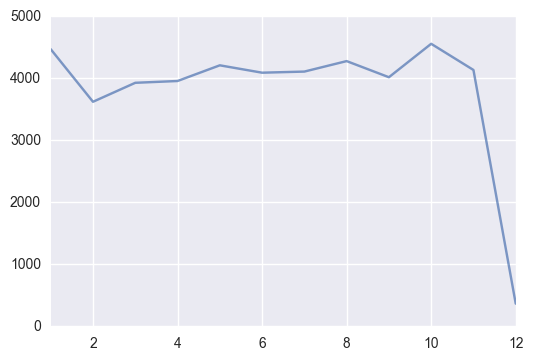

In [8]:
df2.o_date.dt.month.value_counts().sort_index().plot(kind = 'line', alpha = 0.7)

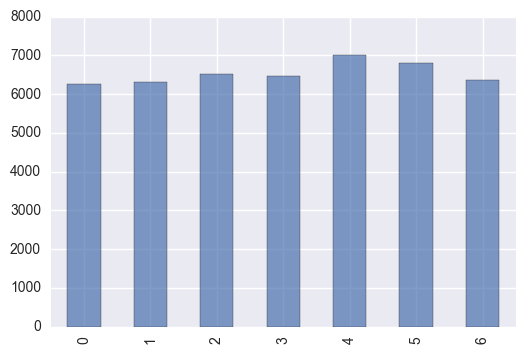

In [9]:
df2.o_date.dt.dayofweek.value_counts().sort_index().plot(kind = 'bar', alpha = 0.7) # 0 = Monday, 6 = Sunday

** Fridays and Saturdays ** have more probability. Now let's see the time of the day:

In [10]:
bins = np.arange(0, 2500, 400)
bins

array([   0,  400,  800, 1200, 1600, 2000, 2400])

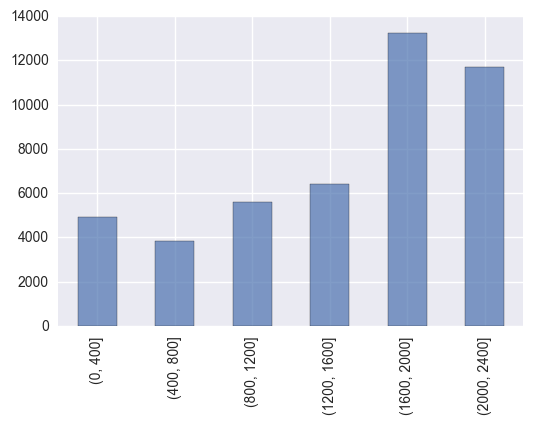

In [11]:
pd.cut(df2.time, bins).value_counts().sort_index().plot(kind = 'bar', alpha = 0.7) # time of the day

Vehicles are more likely to get stolen in between 4:00 -8:00 p.m. & 8:00-12:00 p.m.

<p> Some data clean up:


In [12]:
df5 = df2['loc'].str.strip('()')                               \
                   .str.split(', ', expand=True)                   \
                   .rename(columns={0:'latitude', 1:'longitude'}) 
df5.head(1)

,latitude,longitude
33849,34.2504,-118.5199


In [13]:
df6 = df5.apply(pd.to_numeric)
df6.dtypes

latitude     float64
longitude    float64
dtype: object

In [14]:
lat2 = df6.latitude.tolist()
lon2 = df6.longitude.tolist()

Let's plot all vehicle crime on the LA map.

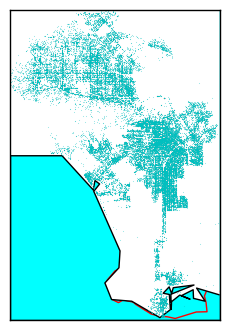

In [15]:
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import numpy as np

 
map = Basemap(
    projection='cass',
    ellps = 'WGS84',
    lat_0 = 34.047495, lon_0 = -118.260712,
    resolution = 'i', area_thresh = 0.5,
    llcrnrlon=-118.66, llcrnrlat=33.70,
    urcrnrlon=-118.15, urcrnrlat=34.33)

map.drawcoastlines()
map.drawcountries()
map.drawstates(color = 'blue', linewidth=3)
map.drawcounties(color = 'red', linewidth=1)
map.fillcontinents(color = 'white')
map.drawmapboundary(fill_color='aqua')
#map.readshapefile('DRP_COUNTY_BOUNDARY\'DRP_COUNTY_BOUNDARY.shp', 'areas')
#map.bluemarble()
LAlat = lat2
LAlon = lon2
xpt, ypt = map(LAlon, LAlat)
map.plot(xpt, ypt, 'c*', markersize = 1, alpha =.7)

plt.show()

#### Now, let's figure out more crime prone areas and apply our model

In [16]:
da = df[['DATE OCC', 'Location 1', 'TIME OCC', 'AREA']]
da.columns = [['crimedate', 'loc', 'time', 'area']]
da.head(1)

,crimedate,loc,time,area
0,2016-09-27 12:00:00,"(34.1877, -118.4421)",900,9


In [17]:
db = da['loc'].str.strip('()')                               \
                   .str.split(', ', expand=True)                   \
                   .rename(columns={0:'latitude', 1:'longitude'}) 
db.head(1)

,latitude,longitude
0,34.1877,-118.4421


In [18]:
db = db.apply(pd.to_numeric)

In [19]:
db.dtypes

latitude     float64
longitude    float64
dtype: object

In [20]:
dc = pd.concat([da, db], axis=1)
dc = dc.drop('loc', 1)
dc.head(1)

,crimedate,time,area,latitude,longitude
0,2016-09-27 12:00:00,900,9,34.1877,-118.4421


In [21]:
dc.dtypes

crimedate    datetime64[ns]
time                  int64
area                  int64
latitude            float64
longitude           float64
dtype: object

In [22]:
dc.groupby('area').size() > 2500 # area 11, 12, 13 & 15

area
1     False
2     False
3     False
4     False
5     False
6     False
7     False
8     False
9     False
10    False
11     True
12     True
13     True
14    False
15     True
16    False
17    False
18    False
19    False
20    False
21    False
dtype: bool

Found that areas ** 11, 12, 13 & 15 ** have more than 2500 incidents.

In [23]:
dhot = dc[(dc.area == 11) | (dc.area == 12) | (dc.area == 13)| (dc.area == 15)]
dhotLat = dhot.latitude.tolist()
dhotLon = dhot.longitude.tolist()
dhot.head()

,crimedate,time,area,latitude,longitude
1,2016-02-05 12:00:00,1730,15,34.1940,-118.3746
10,2016-02-04 12:00:00,2000,11,34.1036,-118.2984
13,2016-01-19 12:00:00,25,11,34.1215,-118.2069
17,2016-06-11 12:00:00,2000,12,33.9591,-118.3112
18,2016-03-30 12:00:00,2100,15,34.1958,-118.3986


#### Let's plot these three areas 

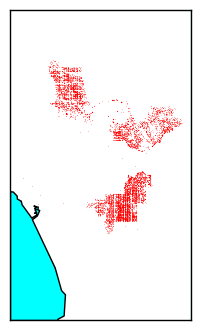

In [24]:
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import numpy as np

map = Basemap(
    projection='cass',
    ellps = 'WGS84',
    lat_0 = 34.047495, lon_0 = -118.260712,
    resolution = 'h', area_thresh = 0.5,
    llcrnrlon=-118.5, llcrnrlat=33.80,
    urcrnrlon=-118.15, urcrnrlat=34.3)
#llcrnrlon=-118.66, llcrnrlat=33.70,
    #urcrnrlon=-118.15, urcrnrlat=34.33
map.drawcoastlines()
map.drawcountries()
map.drawstates(color = 'blue', linewidth=3)
map.drawcounties(color = 'red', linewidth=1)
map.fillcontinents(color = 'white')
map.drawmapboundary(fill_color='aqua')
#map.readshapefile('DRP_COUNTY_BOUNDARY\'DRP_COUNTY_BOUNDARY.shp', 'areas')
#map.bluemarble()
LAlat = dhotLat
LAlon = dhotLon
xpt, ypt = map(LAlon, LAlat)
map.plot(xpt, ypt, 'r*', markersize = 1, alpha =.5)

plt.show()

In [25]:
dhot1 = dhot[['latitude', 'longitude']]
dhot1.head(1)

,latitude,longitude
1,34.194,-118.3746


In [26]:
dhot3 = dhot1.query('-118.5 < longitude < -118.15')
dhot3.shape

(11002, 2)

In [27]:
dhot2 = dhot1[dhot1['longitude'].between(-118.5, -118.15, inclusive=True)]
dhot2.shape

(11002, 2)

In [28]:
dhot2.head(1)

,latitude,longitude
1,34.194,-118.3746


In [29]:
dhot1.shape

(11062, 2)

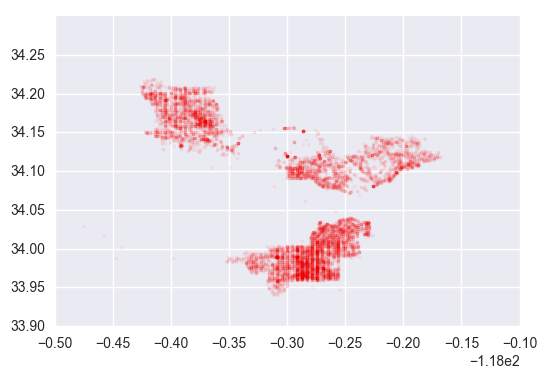

In [30]:
fig = plt.figure() # hot crime with more than 2500 incidents in 2016
ax = fig.add_subplot(111)
ax.scatter(dhot2.longitude, dhot2.latitude, marker='.', color ='r', alpha=0.05)
ax.set_ylim([33.9, 34.3])
#ax.set_xlim([-118.15, -118.5])
plt.show()

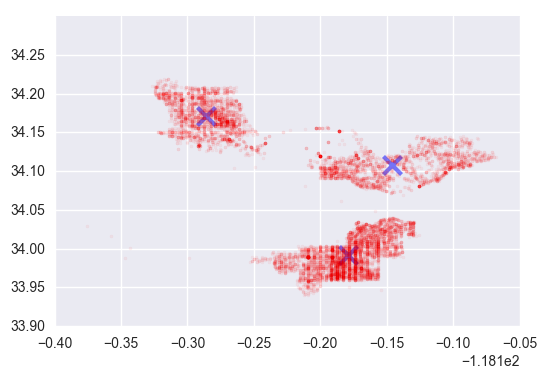

[[  33.99125226 -118.27885508]
 [  34.1082496  -118.24573593]
 [  34.17092224 -118.38629778]]


In [31]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=3)
kmeans.fit(dhot2)
KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=3, n_init=10,
    n_jobs=1, precompute_distances='auto', random_state=None, tol=0.0001,
    verbose=0)

labels = kmeans.predict(dhot2)
centroids = kmeans.cluster_centers_
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_ylim([33.9, 34.3])
#ax.set_xlim([-118.15, -118.5])
ax.scatter(centroids[:, 1], centroids[:, 0], marker='x', c='blue', alpha=0.5, linewidths=3, s=169)
ax.scatter(dhot2.longitude, dhot2.latitude, marker='.', color ='r', alpha=0.05)
plt.show()
print centroids

I checked for these locations on google map.  Two of these locations are close to a highways. 

<li> Future work: directly plot them on google maps in this notebook. (gmplot did not work here)
<li> measure the distance between center and locations to areas of interest (parking lot, highways, movie theaters, residents). 

<p> Let's see some other cluster centers. 

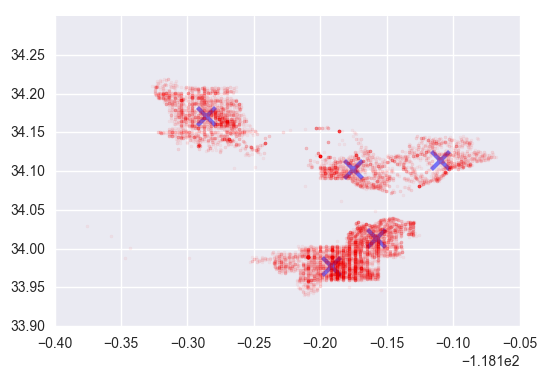

[[  34.10333716 -118.27548976]
 [  34.01333327 -118.25781395]
 [  34.17102352 -118.38632699]
 [  34.11428312 -118.20967882]
 [  33.97794244 -118.29159699]]


In [32]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=5)
kmeans.fit(dhot2)
KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=3, n_init=10,
    n_jobs=1, precompute_distances='auto', random_state=None, tol=0.0001,
    verbose=0)

labels = kmeans.predict(dhot2)
centroids = kmeans.cluster_centers_
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_ylim([33.9, 34.3])
#ax.set_xlim([-118.15, -118.5])
ax.scatter(centroids[:, 1], centroids[:, 0], marker='x', c='blue', alpha=0.5, linewidths=3, s=169)
ax.scatter(dhot2.longitude, dhot2.latitude, marker='.', color ='r', alpha=0.05)
plt.show()
print centroids